## Yashi Game Implementation
Philippe Robert



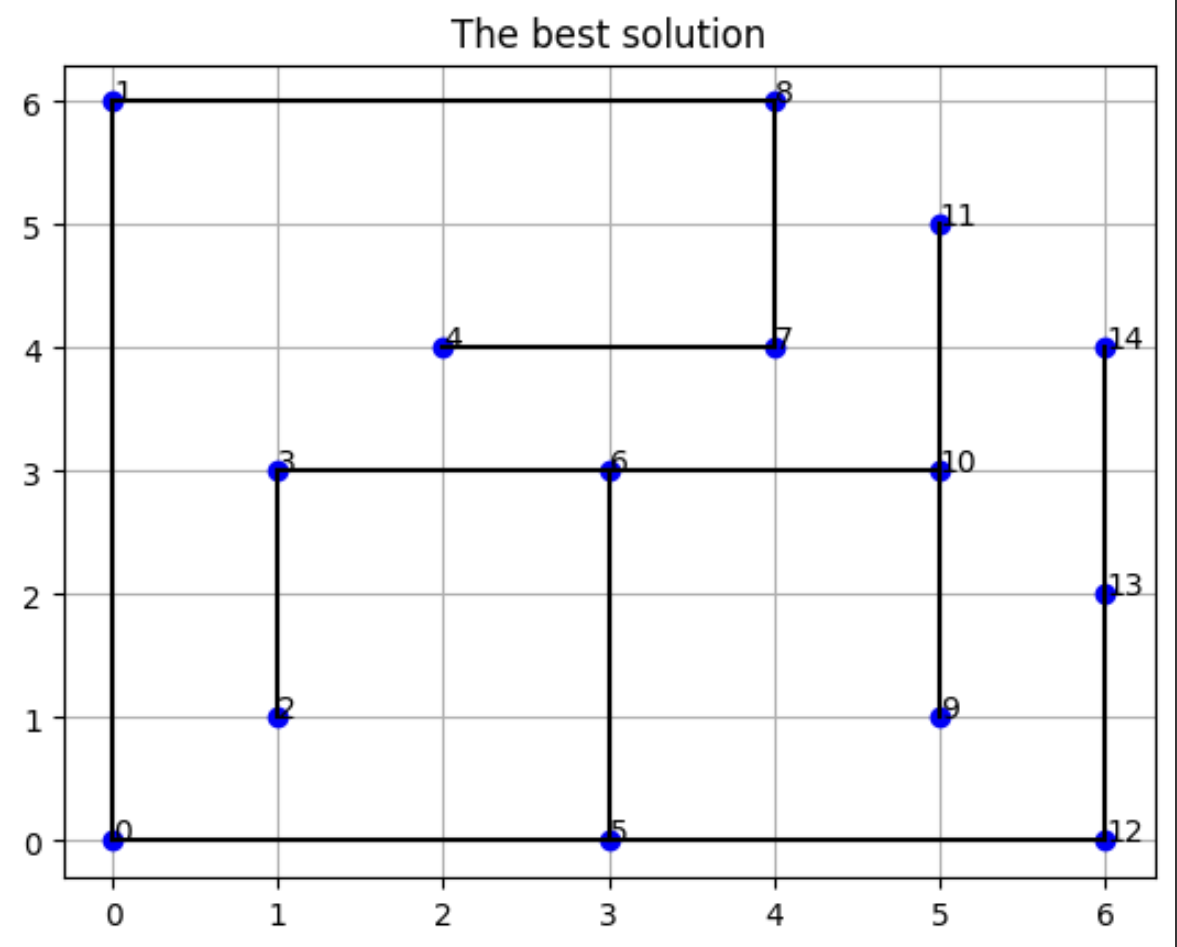

## Quick introduction

The Yashi game can encompasses three distinct challenges, each more complex than the last:



* **Version 1**: Determine whether there is a valide solution.
* **Version 2**: If a solution is possible, calculate the total number of solutions.
* **Version 3**:If a solution exists, identify the one with the least cost.

The Game involves creating a planar spanning tree on a Cartesian grid by connecting a set of points. This game is structured with specific rules:
1. Only horizontal and vertical lines are permitted, excluding diagonals. Therefore, no overlap in a grid context.
2. All points must be connected.
3. Lines should not cross each other.
4. The total number of lines used must be exactly $n-1$, where $n$ represent the total number of points
5. The structure must not form any cycles.

The constraints 4 and 5 is equivalent of the segment forming a tree (a graph without cycle)

The first two constraints are verified during the initial setup phase. The constraints 3, 4, 5 are managed through SAT techniniques afterward.



## Initial setup phase - Constraint 1

We first install the pysat library and import all the libraries required.

In [ ]:
!pip install python-sat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.6 MB/s eta 0:00:00


In [ ]:
import math
import matplotlib.pyplot as plt
from pysat.solvers import Minisat22
from pysat.examples.fm import FM
from pysat.formula import WCNF
from itertools import chain
from collections import defaultdict, deque
from io import StringIO
from typing import List, Set, Dict, NewType, Tuple
import pandas
from collections import defaultdict
from pysat.formula import WCNF
from pysat.formula import WCNF
import itertools

Lets create some type aliases that we will use later:

- **id_point**: the identifier of a point;
- **id_line**: the identifier of a line;
- **coordinate**: it represents a coordinate of a point;
- **point**: it represents a point of the game as a tuple of coordinates, e.g. $p_1 = (3, 2)$;
- **line**: it represents a line of the game as a tuple of points, e.g. $l_1 = (p_1 = (3, 3), p_2 = (3, 2))$.


In [ ]:
id_point = NewType("id_point", int)
id_line = NewType("id_line", int)
coordinate = NewType("coordinate", float)
Point = NewType("point", Tuple[coordinate, coordinate])
Line = NewType("line", Tuple[id_point, id_point])

Now lets initialize the game from the file. Here is the information about what is returned by the following process:

* **lines_dict**: dictionary that ties the line identifier to itself;
* **points_dict**: dictionary that ties the point identifier to itself;
* **points_Line_dict**: dictionary that ties two points to the line composed by them.

Each line drawn from a starting point A to an endpoint B adheres to a specific rule: the path from A to B must be the only and shortest non-diagonal route possible. **This approach effectively addresses the first constraint of the game, ensuring unique and direct connections between points.**

In [ ]:
"""
Type Aliases: created for better code readability and structure.

Initialization: The function yashi_init takes "df" representing the game's grid and initializes various
 structures: Lines_dict, Points_dict, and Points_line_dict.

Creating Points: It iterates through df to create points, storing them in points_dict and placing them on a grid,
 which is a defaultdict of dicts, representing the game's grid.

Generating Lines: The code then generates lines by iterating over each point (v). For each point, it looks in four
 directions (up, down, right, left) to find the closest point (u) in each direction.

Addressing Constraint 1 (No Diagonal Lines): By considering only the vertical and horizontal neighbors
 (up, down, right, left) for line creation, it ensures no lines are diagonal. This is done within the
  nested for-loops by checking grid positions relative to the current point.

Line Uniqueness and Storage: Each line is assigned a unique id_line and stored in lines. It also updates
 points_lines_dict to map points to their connecting lines and addedLines to track added lines.

Return Values: Finally, it returns lines, points_dict, and points_lines_dict for further use in the game's logic.
"""
Lines_dict = NewType("Lines", Dict[id_line, Line])
Points_dict = NewType("Points", Dict[id_point, Point])
Points_line_dict = NewType("Points to line", Dict[id_point, Dict[id_point, id_line]])

#initialize the strucrure
def yashi_init(df: pandas.DataFrame) -> Tuple[Lines_dict, Points_dict, Points_line_dict]:
    size = len(df)
    grid = defaultdict(dict)
    points_dict = dict()
    lines = dict()

    #we create the points by itering in df and set them to the grid
    for _, row in df.iterrows():
        p, x, y = row["point"], row["x"], row["y"]
        points_dict[p] = (x, y)
        grid[x][y] = p

    addedLines = defaultdict(bool)
    points_lines_dict = defaultdict(dict)

    #now lets generates lines by iterating over each point (v)
    j = 1
    for v, (r, c) in points_dict.items():

        #creat lines from a point v to closest point above
        for i in range(r + 1, size):
            u = grid[i].get(c, None)
            if u != None:
                u_v = (u, v) if u <= v else (v, u)
                if not addedLines[u_v]:
                    lines[j] = (v, u)
                    points_lines_dict[u][v] = j
                    points_lines_dict[v][u] = j
                    addedLines[u_v] = True
                    j += 1
                break

        #creat lines from a point v to closest point below
        for i in range(r - 1, -1, -1):
            u = grid[i].get(c, None)
            if u != None:
                u_v = (u, v) if u <= v else (v, u)
                if not addedLines[u_v]:
                    lines[j] = (v, u)
                    points_lines_dict[u][v] = j
                    points_lines_dict[v][u] = j
                    addedLines[u_v] = True
                    j += 1
                break

        #creat lines from a point v to the closest point to its right
        for i in range(c + 1, size):
            u = grid[r].get(i, None)
            if u != None:
                u_v = (u, v) if u <= v else (v, u)
                if not addedLines[u_v]:
                    lines[j] = (v, u)
                    points_lines_dict[v][u] = j
                    points_lines_dict[u][v] = j
                    addedLines[u_v] = True
                    j += 1
                break

        #creat lines from a point v to the closest point to its left
        for i in range(c - 1, -1, -1):
            u = grid[r].get(i, None)
            if u != None:
                u_v = (u, v) if u <= v else (v, u)
                if not addedLines[u_v]:
                    lines[j] = (v, u)
                    points_lines_dict[v][u] = j
                    points_lines_dict[u][v] = j
                    addedLines[u_v] = True
                    j += 1
                break

    return lines, points_dict, points_lines_dict

The file format or the game setings manually input to pass to the function have this format:
```cvs
point,x,y
---,---,---
```
where:
* *point*: name of the point, e.g. 0, 1, 2, A, B, C, etc.;
* *x*: the x of the point;
* *y*: the y of the point.

As example with (3,5,2), the 3 is the point name, 5 the value of its x-axis ans 2 the value of its y-axis.


The function *yashi_plot* aims at plotting the game given the points and lines.

In [ ]:
"""
Point Plotting: we first iterates through the points dictionary to extracts the row (r) and column (c) coordinates,
 appending them to lists x and y. We also annotates each point on the plot with its name.

Line Plotting: the function iterates over the lines dictionary. For each line, it retrieves the coordinates
 of the two connecting points (u, v) from points. It then plots a line between these points.

"""


def yashi_plot(lines: Lines_dict, points: Points_dict, title=""):
    x = []
    y = []

    #plot the points
    for name in points:
        r, c = points[name]
        x.append(r)
        y.append(c)
        plt.annotate(name, (r, c))

    plt.plot(x, y, "bo")

    #plot the lines
    for u, v in lines.values():
        (x1, y1), (x2, y2) = points[u], points[v]
        plt.plot([x1, x2], [y1, y2], "k-")

    plt.title(title)
    plt.grid(True)
    plt.show()

## Initial setup phase - Constraint 2

To address the second constraint, a graph-based approach is used due to its efficiency, with a complexity of $O(n)$, where *n* is the number of vertices. This involves using a Depth First Search (DFS) to assess if the game's points form a connected graph. This step, independent of SAT, counts the number of connected components, which are subgraphs where all node pairs are interlinked. A connected graph has only one component; if DFS doesn't visit all vertices in one pass, the graph isn't connected. This is more efficient than a SAT approach, which would require managing a large number of constraints.

Lets introduce the class Graph that will be useful to check some propreties of the game. It is designed to handle undirected graphs using an adjacency list format. This means the graph is depicted as a list containing other lists, where each list represents a vertex and contains its adjacent vertices. Thus, it help to find all cycles.



In [ ]:
"""
The class implemented are the following:
- get_n: returns the number of nodes;
- get_m: returns the number of edges;
- get_vertices: returns all the vertices;
- get_weight: given 's' and 't' vertices, if there is an edge between 's' and 't', then it returns the weight, otherwise it returns 'None';
- get_edges: returns all the edges;
- get_adj_list_v: if 's' exists it returns the adjacent list of the vertex 's', otherwhise 'None';
- add_edge: given 's', 't' and 'w' it creates the edges from 's' to 't' with weight 'w' and vice-versa in the adjacent list and add them to the set of edges;
- remove_edge: given 's' and 't', if exist an edge between them it will be deleted;
- __eq__: overloading of the operator ==, where given an another graph it checks if they have the same edges;
- __hash__: returns the hash of the edges;
- __xor__: the most important operator, which returns a new graph made up by all the non common edges between two graphs
"""

"""
Initialization: Constructs a graph from a given set of edges, creating an adjacency list and a set of edges.

Graph Operations: Includes methods to retrieve the number of nodes (get_n), edges (get_m), all vertices (get_vertices),
 and all edges (get_edges). It can also find the weight of an edge (get_weight) and provide the adjacency list for
  a given vertex (get_adj_list_v).

Edge Manipulation: Allows adding (add_edge) and removing (remove_edge) edges.

Special Methods: Implements methods for equality comparison (__eq__), hashing (__hash__),
 and symmetric difference (__xor__) between two graphs.

Graph Instantiation for Yashi Game: The function init_graph uses the Graph class to create a graph from the lines
 generated during the initialization of the Yashi game. It helps us in assessing whether all points are connected
  as per the second constraint.
"""

Edge = NewType("Edge", Tuple[float, float, float])
Vertex = NewType("Vertex", float)

class Graph:
    def __init__(self, edges=[]):
        '''build an object starting from a set of edges'''
        self.adj_list = defaultdict(dict)
        self.edges = set()
        for s, t, w in edges:
            self.add_edge(s, t, w)

    def get_n(self):
        '''returns the number of nodes'''
        return len(self.adj_list)

    def get_m(self):
        '''returns the number of edges'''
        return len(self.edges)

    def get_vertices(self):
        '''returns all the vertices'''
        return self.adj_list.keys()

    def get_weight(self, s, t):
        '''given s and t vertices,
        if exist an edge between s and t it returns the weight,
        otherwise it returns None'''
        return self.adj_list[s].get(t, None)

    def get_edges(self):
        '''returns all the edges'''
        return self.edges

    def get_adj_list_v(self, s):
        '''if s exists it returns the adjacent list of the vertex s, otherwhise None'''
        return self.adj_list[s].keys()

    def add_edge(self, s, t, w=1):
        '''given s, t and w it creates the edges from s to t
        with weight w and vice-versa in the adjacent list
        and add them to the set of edges'''
        self.adj_list[s][t] = w
        self.adj_list[t][s] = w

        self.edges.add((s, t, w))
        self.edges.add((t, s, w))

    def remove_edge(self, s, t):
        '''given s and t, if exist an edge between them it will be deleted'''
        w = self.adj_list[s].get(t, None)
        if w != None:
            del self.adj_list[s][t]
            del self.adj_list[t][s]
            self.edges.remove((s, t, w))
            self.edges.remove((t, s, w))

    def __eq__(self, other: object) -> bool:
        '''given an another graph it checks if they have the same edges'''
        return self.edges == other.edges

    def __hash__(self):
        '''returns the hash of the edges'''
        return hash(frozenset(self.edges))

    def __xor__(self, other):
        '''returns a new graph made up by
        all the non common edges between two graphs'''
        g1_edges = self.get_edges()
        g2_edges = other.get_edges()

        edges = g1_edges.union(g2_edges)
        inter = g1_edges.intersection(g2_edges)

        return Graph(edges - inter)

    def __str__(self) -> str:
        return f"{self.edges}"

    def __repr__(self) -> str:
        return self.__str__()


#function that instanciate a graph with the line generated during the inizialization above
def init_graph(lines: Lines_dict) -> Graph:
    g = Graph()
    for (u, v) in lines.values():
        g.add_edge(u, v)
    return g

Here we have the code that checks the constraint.

In [ ]:
"""
deep_first_search Function: Uses DFS to traverse the graph G. It marks each visited vertex and continues to explore
 its adjacent vertices, ensuring not to revisit the vertex from which it came (parent).
  This method helps us in exploring each connected component of the graph.

is_connected Function: Determines if the graph G is fully connected. It initializes a visited dictionary to track
 visited vertices and a counter k for connected components. The function iterates over all vertices and,
  for each unvisited vertex, increments k and calls deep_first_search. If k is incremented more than once,
   it implies the graph has more than one connected component, hence not fully connected. The graph
    is considered connected if k equals 1, meaning all vertices are visited in one DFS run.
"""

def deep_first_search(G: Graph, v: Vertex, parent: Vertex, visited):
    visited[v] = True
    for u in G.get_adj_list_v(v):
        if u != parent:
            if not visited[u]:
                deep_first_search(G, u, v, visited)


def is_connected(G: Graph) -> bool:
    '''Returns True if the first run of DFS visits all the vertices and therefore
    the number of components hasn't been incremented more than once'''
    visited = {v: False for v in G.get_vertices()}
    k = 0 # Number of connected components
    for v in G.get_vertices():
        if not visited[v]:
            k += 1
            if k != 1: # Returns False if the number of components has been incremented more than once
                return False
            deep_first_search(G, v, None, visited)

    return True

## Remaining conditions

The constraints 3, 4 and 5 are enough to state the conditions to make graph that connects all vertices (points) in a planar graph without forming any cycles. It can be formulated with the following fomuls $ϕ = ϕ_{no\_crossing} \land ϕ_{n-1\_lines} \land ϕ_{no\_cycles}$,

In this context, 'literals' refer to identifiers assigned to lines, which are numbered starting from 1. This numbering is based on the order in which they are created during the initialization phase of the process.

### Condition 3 - No crossing lines


In [ ]:
"""
line_crossing Function: Help us determineing if two lines l1 and l2 cross each other by:
  - Extracts the coordinates of the endpoints of both lines.
  - Checks if one line is vertical and the other is horizontal, since only such pairs can cross
  - Determines if the vertical line's x-coordinate is between the horizontal line's x-coordinates, and
    the horizontal line's y-coordinate is between the vertical line's y-coordinates
  - If both conditions are true, the lines cross; otherwise, they don't.

no_crossing Function: Generates a WCNF (Weighted Conjunctive Normal Form) formula representing the constraints:
  - Iterates through all pairs of lines
  - Uses line_crossing to check if a pair of lines cross
  - For each pair that crosses, adds a clause to the WCNF that prevents both lines from being used simultaneously in the solution
"""


def line_crossing(l1: Line, l2: Line, points: Points_dict) -> bool:
    (l1_p1_x, l1_p1_y), (l1_p2_x, l1_p2_y) = points[l1[0]], points[l1[1]]
    (l2_p1_x, l2_p1_y), (l2_p2_x, l2_p2_y) = points[l2[0]], points[l2[1]]

    if l1_p1_x == l1_p2_x: #checking if l1 is horizontal
        a_x, b_x = (l2_p1_x, l2_p2_x) if l2_p1_x < l2_p2_x else (l2_p2_x, l2_p1_x)
        if l2_p1_y == l2_p2_y: #checking if l2 is vertical, otherwise they aren't crossing
            a_y, b_y = (l1_p1_y, l1_p2_y) if l1_p1_y < l1_p2_y else (l1_p2_y, l1_p1_y)
            #checking if the l1 points are between l2 points
            return (l1_p1_x > a_x and l1_p1_x < b_x) and (
                l2_p1_y > a_y and l2_p1_y < b_y
            )
        else:
            return False
    else:  #l1_p1_y == l1_p2_y, l1 is vertical
        a_y, b_y = (l2_p1_y, l2_p2_y) if l2_p1_y < l2_p2_y else (l2_p2_y, l2_p1_y)
        if l2_p1_x == l2_p2_x: #checking if l2 is horizontal, otherwise they aren't crossing
            a_x, b_x = (l1_p1_x, l1_p2_x) if l1_p1_x < l1_p2_x else (l1_p2_x, l1_p1_x)
            #checking if the l1 points are between l2 points
            return (l1_p1_y > a_y and l1_p1_y < b_y) and (
                l2_p1_x > a_x and l2_p1_x < b_x
            )
        else:
            return False


def no_crossing(lines: Lines_dict, points: Points_dict) -> WCNF:
    phi_no_crossing = WCNF()
    items = list(lines.items())
    #checking if two lines are crossing,
    #if so append the formula that forces to not use them at once
    for index, (l1_id, l1) in enumerate(items):
        for l2_id, l2 in items[index + 1 :]:
            if line_crossing(l1, l2, points):
                phi_no_crossing.append([-l1_id, -l2_id])

    return phi_no_crossing

### Constraint 4 - total number of lines used must be exactly $n-1$

In [ ]:
"""
exactly_k: Accepts a list of literals (lines) and an integer k representing the exact number of lines that must be used

WCNF for At Least k Lines: It uses the combinations function from the itertools module to generate all possible subsets
 of the literals list with n - k + 1 elements. For each subset, a clause is added to the CNF expression,
  which dictates that at least k literals must be true.

WCNF for At Most k Lines: It generates all possible subsets of the literals list with k + 1 elements. For each subset,
 a clause is added with the negated literals, ensuring that no more than k literals can be true simultaneously.

Return WCNF: The function returns a WCNF object that encodes the constraint requiring exactly k lines to be used
"""


def exactly_k(lits, k: int) -> WCNF:
    phi = WCNF()
    n = len(lits)

    #at least k
    for sub_lits in itertools.combinations(lits, n - k + 1):
        phi.append([lit for lit in sub_lits])

    #at most k
    for sub_lits in itertools.combinations(lits, k + 1):
        phi.append([-lit for lit in sub_lits])

    return phi

### Constraint 5 - No cycles

In [ ]:
"""
Cycle identification: We defines a type Cycle as a set of Edge objects and introduces a powerset function to
 generate all possible subsets of a set, which will be used to explore different cycle combinations.

get_path_from_to: Function that constructs the path in a graph from vertex v to vertex u using parent pointers.

get_fundamental_cycles: Function that generates the fundamental cycles in a graph given a starting vertex r. It
 uses a BFS-like approach to traverse the graph, marking vertices as part of the spanning tree T. When it encounters
  an already visited vertex, it identifies a cycle formed by the path from r to v, the path from r to u, and the edge (u, v).

get_cycles: Function takes the fundamental cycles and generates all possible cycles by taking the powerset of the fundamental
 cycles and symmetrically subtracting (using XOR) the cycles to get new ones.
"""

Cycle = NewType("Cycle", Set[Edge])

def powerset(iterable):
    '''returns the powerset of a set'''
    s = list(iterable)
    return chain.from_iterable(itertools.combinations(s, r) for r in range(len(s) + 1))


def get_path_from_to(G: Graph, v: Vertex, u: Vertex, parents) -> Graph:
    '''returns a graph representing the path from v to u'''
    path = Graph()
    cur = u
    while cur != None and cur != v:
        p = parents[cur]
        path.add_edge(cur, p, G.get_weight(cur, p))
        cur = p

    return path


def get_fundamental_cycles(G: Graph, r: Vertex) -> Set[Graph]:
    '''returns a set of graphs represting the fundamental cycles'''
    in_t = defaultdict(bool)
    T = Graph()
    Q = deque([r])
    parents = defaultdict(lambda: None)
    cycles = set()

    while Q:
        v = Q.popleft()
        for u in G.get_adj_list_v(v):
            if u != parents[v]:
                if in_t[u]:
                    r_v_path = get_path_from_to(T, r, v, parents)
                    r_u_path = get_path_from_to(T, r, u, parents)
                    cycle = r_u_path ^ r_v_path
                    cycle.add_edge(u, v, G.get_weight(u, v))
                    cycles.add(cycle)
                else:
                    Q.append(u)
                    in_t[u] = True
                    T.add_edge(v, u, G.get_weight(v, u))
                    parents[u] = v

    return cycles


def get_cycles(G: Graph) -> List[Cycle]:
    '''returns a list containing all the cycles got from
    the fundamental cycles'''
    r = list(G.get_vertices())[0]
    fundamental_cycles = get_fundamental_cycles(G, r)
    cycles = []
    for subset in powerset(fundamental_cycles):
        if subset:
            new_cycle = Graph()
            for cycle in subset:
                new_cycle = new_cycle ^ cycle
            cycles.append(new_cycle.get_edges())

    return cycles

Now that we have all the cycles. We can use the formula

$\phi_{no\_cycles} = CNF(\bigwedge_\limits{c \in Cycles} \overline{\bigwedge_\limits{l \in c} l}) = \bigwedge_\limits{c \in Cycles} \bigvee_\limits{l \in c} \overline{l}$

which state the constraint given a set of cycles made up by some literals.
The function *constraint_no_cycles* creates the formula, while *no_cycles* get all the cycles and get the formula to return to the caller.

In [ ]:
"""
constraint_no_cycles: Creates a WCNF object that encodes the constraint that none of the cycles can be present in a valid solution.

WCNF: We iterates over all cycles, creating a constraint for each cycle where at least one edge in the cycle must not be present
 (using the negated literals).

no_cycles: Function that combines the above steps by obtaining all cycles from get_cycles and then using constraint_no_cycles
 to encode the no cycle constraint into a WCNF object.
"""

def constraint_no_cycles(cycles: List[Cycle], pointsToLines: Points_line_dict) -> WCNF:
    phi_no_cycles = WCNF()

    for cycle in cycles:
        constraint = []
        for u, v, _ in cycle:
            constraint.append(-pointsToLines[u][v])
        if constraint:
            phi_no_cycles.append(constraint)

    return phi_no_cycles


def no_cycles(G: Graph, pointsToLines: Points_line_dict) -> WCNF:
    cycles = get_cycles(G)
    phi_no_cycles = constraint_no_cycles(cycles, pointsToLines)

    return phi_no_cycles

### Principal code

This part compiles all the previously defined constraints and produces a Weighted CNF (WCNF), specifically tailored for solving Problem 3 of the Yashi Game. This means it's designed to find the solution with the minimum cost.

In [ ]:
"""
Calculates Necessary Lines: Determines k, the required number of lines (n - 1 where n is the number of points).

Gathers Constraints: Generates non-crossing, no-cycle, and exact line count constraints.

Combines Constraints: Merges the constraints into one WCNF object (suitable for version three of the game).

Returns WCNF: Outputs the combined WCNF containing all hard constraints for the Yashi game.
"""
def basic_constraints(G: Graph, lines: Lines_dict, points: Points_dict, pointsToLine: Points_line_dict) -> WCNF:
    phi = WCNF()
    k = len(points) - 1

    phi_no_crossing = no_crossing(lines, points)
    phi_no_cycles = no_cycles(G, pointsToLine)
    phi_tree = exactly_k(lines.keys(), k)

    phi.extend(phi_no_crossing.hard)
    phi.extend(phi_no_cycles.hard)
    phi.extend(phi_tree.hard)

    return phi

## Problem 1: Check for existence

To solve the version of the game P1, we need to:
- initialize with the game's setting;
- check if it's connected or not;
- get all the constraints to apply to the solver by calling *basic_constraints*;
- if a solution exists, get a model from the solution obtained by the solver.

There will be two plots: one of the game to solve and one of the proposed solution.

In [ ]:
"""
Initializes Game: Reads game data from a file, or manually input settings and initializes game
 components (lines, points, and mappings).

Plots Initial State: Displays the game setup without any connections.

Connectivity Check: Verifies if all points are connected to form a valid graph structure.

Solves Constraints: If connected, it compiles the game's basic constraints into a formula and uses a SAT solver to find a solution.

Displays Solution: If a solution exists, it extracts the model from the solver, identifies the lines used, and plots the solution;
 otherwise, it prints "No solution".
"""

def existence_solver(file):
    y_csv = pandas.read_csv(file)
    solver = Minisat22()
    lines, points, pointsToLines = yashi_init(y_csv)
    G = init_graph(lines)

    yashi_plot({}, points, "The game")

    if is_connected(G):
      phi = basic_constraints(G, lines, points, pointsToLines)
      solver.append_formula(phi.hard)

      solution = solver.solve()

      if solution:
          model = solver.get_model()
          model_lines = {x: lines[x] for x in model if x > 0}

          yashi_plot(model_lines, points, "The solution")
      else:
          print("No solution")
    else:
        print("No solution")

## Problem 2: Count how many solutions

To solve the version of the game P2, we need to:
- initialization with the game's settings;
- check if it's connected or not;
- get all the constraints to apply to the solver by calling *basic_constraints*;
- if there exists a solution, count how many models there are.

I built two variation of the code. The first one prints only how many models there are, while the other one prints each models.

In [ ]:
"""
Setup: Starts by reading the game data, initializing the game state, and plotting the initial layout without connections

Solution Existence: The game's connectivity is assessed. If connected, the basic constraints are compiled and passed to the SAT solver

Counting Solutions: Upon finding a solution, the solver enters a loop to enumerate and count all possible models (solutions)

Output Result: The total number of solutions is printed out. If no solution exists, it informs the user.

For model_counting_and_plot_solver specifically: In addition to counting, each found solution is also visualized and plotted with
 a label indicating its sequence number.
"""


def model_counting_solver(file):
    y_csv = pandas.read_csv(file)
    solver = Minisat22()
    lines, points, pointsToLines = yashi_init(y_csv)
    G = init_graph(lines)

    yashi_plot({}, points, "The game")

    if is_connected(G):
      phi = basic_constraints(G, lines, points, pointsToLines)
      solver.append_formula(phi.hard)

      solution = solver.solve()

      if solution:
          n_sol = 0
          for _ in solver.enum_models():
              n_sol += 1

          print("Number of solutions: ", n_sol)
      else:
          print("No solution")

    else:
        print("No solution")

def model_counting_and_plot_solver(file):
    y_csv = pandas.read_csv(file)
    solver = Minisat22()
    lines, points, pointsToLines = yashi_init(y_csv)
    G = init_graph(lines)

    yashi_plot({}, points, "The game")

    if is_connected(G):
      phi = basic_constraints(G, lines, points, pointsToLines)
      solver.append_formula(phi.hard)

      solution = solver.solve()

      if solution:
          n_sol = 0
          for model in solver.enum_models():
              n_sol += 1
              model_lines = {x: lines[x] for x in model if x > 0}
              yashi_plot(model_lines, points, "Solution number: " + str(n_sol))

          print("Number of solutions: ", n_sol)
      else:
          print("No solution")
    else:
        print("No solution")

## Problem 3: Minimum cost solution

In [ ]:
"""
Distance Calculation: Defines euclidian_distance to compute the length of the lines between points

Cost Constraints: The minimum_cost_solution_constraints function assigns weights to each line based on
 their Euclidean distance, representing the cost.

Optimization Setup: After setting up the game and checking for connectivity, the function combines the
 hard constraints (basic game rules) with the soft constraints (line costs).

Solver Execution: Utilizes a Weighted SAT solver to find the model that satisfies all hard constraints
 and minimizes the total cost.

Solution and Cost Output: If a solution is found, it prints the cost and visualizes the optimal solution;
 if not, it reports the absence of a solution.
"""

def euclidian_distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def minimum_cost_solution_constraints(lines, points, pointsToLines) -> WCNF:
    phi = WCNF()
    for (u, v) in lines.values():
        phi.append(
            [pointsToLines[u][v]], weight=-euclidian_distance(points[u], points[v])
        )
    return phi


def best_solution_solver(file):
    y_csv = pandas.read_csv(file)
    lines, points, pointsToLines = yashi_init(y_csv)
    G = init_graph(lines)

    yashi_plot({}, points, "The game")

    if is_connected(G):
      phi_hard = basic_constraints(G, lines, points, pointsToLines)
      phi_soft = minimum_cost_solution_constraints(lines, points, pointsToLines)

      phi = WCNF()
      phi.extend(phi_hard.hard)
      phi.extend(phi_soft.soft, weights=phi_soft.wght)

      solver = FM(phi, verbose=0)

      sol = solver.compute()

      if sol:
          model = solver.model
          print("Cost of the solution: ", -sum(phi_soft.wght) + solver.cost)

          model_lines = {x: lines[x] for x in model if x > 0}
          yashi_plot(model_lines, points, "The best solution")
      else:
          print("No solution")
    else:
        print("No solution")

## Examples

### Real Yashi Game 7x7

In [ ]:
real_yashi_game7x7 = """
point,x,y
0,0,0
1,0,6
2,1,1
3,1,3
4,2,4
5,3,0
6,3,3
7,4,4
8,4,6
9,5,1
10,5,3
11,5,5
12,6,0
13,6,2
14,6,4
"""

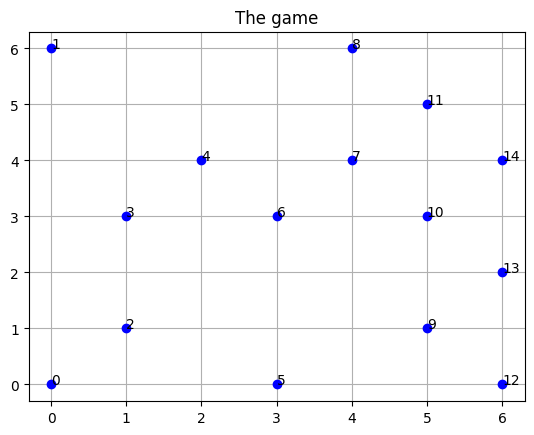

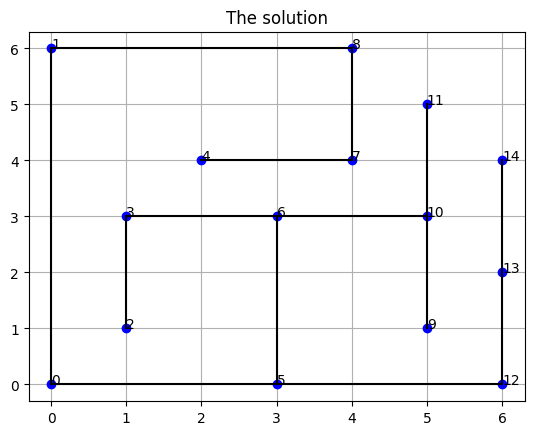

In [ ]:
existence_solver(StringIO(real_yashi_game7x7))

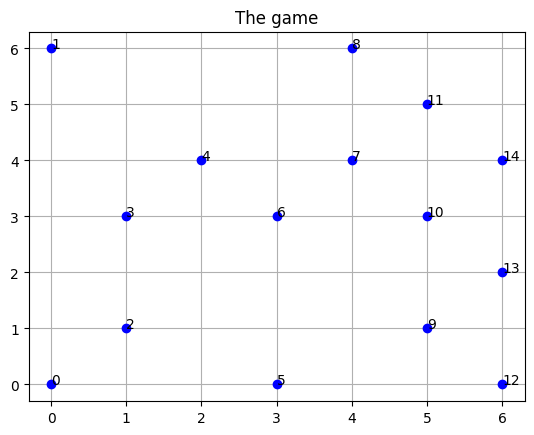

Number of solutions:  1


In [ ]:
model_counting_solver(StringIO(real_yashi_game7x7))

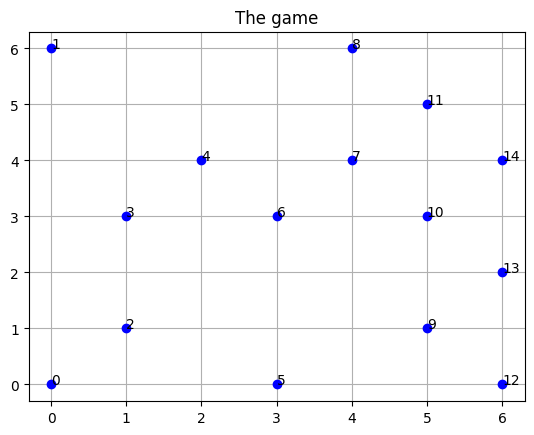

Cost of the solution:  37.0


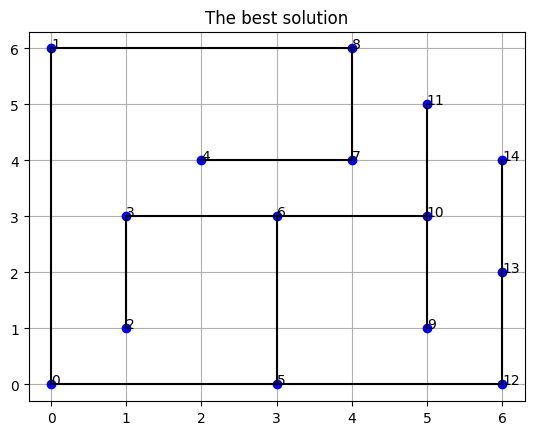

In [ ]:
best_solution_solver(StringIO(real_yashi_game7x7))

### Real Yashi Game 9x9

In [ ]:
real_yashi_game9x9 = """
point,x,y
0,0,2
1,0,6
2,1,0
3,1,4
4,1,7
5,2,6
6,3,8
7,4,0
8,4,2
9,4,4
10,4,7
11,5,5
12,6,1
13,7,0
14,7,2
15,7,5
16,7,7
17,8,1
18,8,4
19,8,8
"""

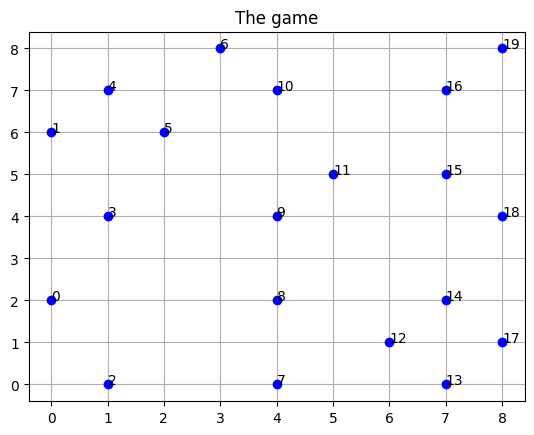

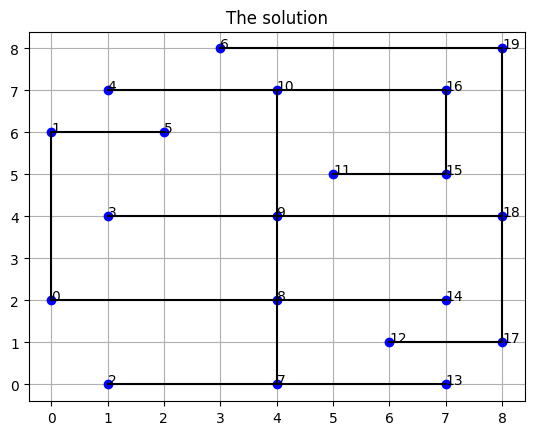

In [ ]:
existence_solver(StringIO(real_yashi_game9x9))

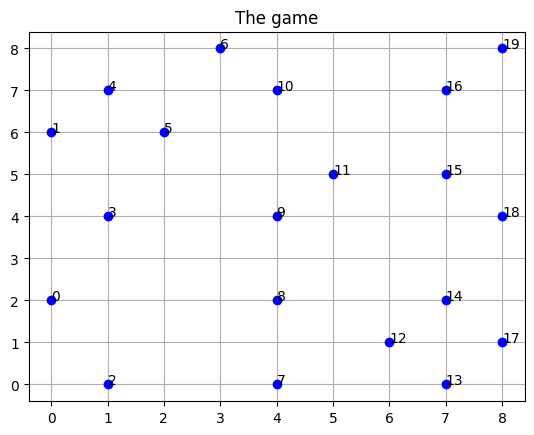

Number of solutions:  1


In [ ]:
model_counting_solver(StringIO(real_yashi_game9x9))

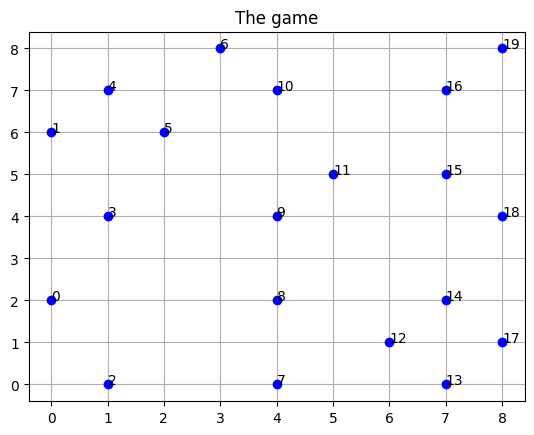

Cost of the solution:  57.0


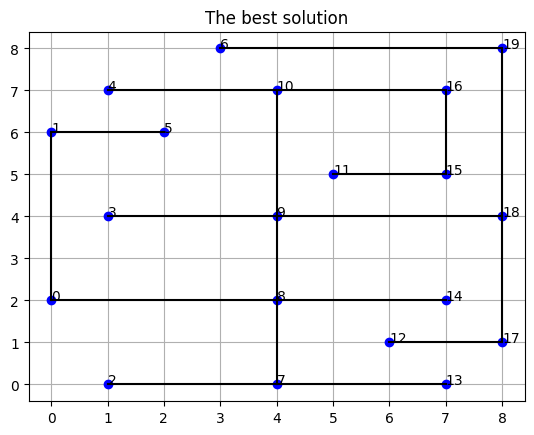

In [ ]:
best_solution_solver(StringIO(real_yashi_game9x9))

### Real Yashi Game 10x10

In [ ]:
real_yashi_game10x10 = """
point,x,y
0,0,2
1,0,5
2,1,0
3,1,4
4,1,7
5,1,9
6,2,1
7,2,5
8,3,2
9,3,4
10,4,1
11,5,9
12,5,0
13,5,2
14,5,5
15,5,7
16,6,9
17,7,0
18,7,7
19,8,2
20,8,4
21,8,9
22,9,3
23,9,5
24,9,8
"""

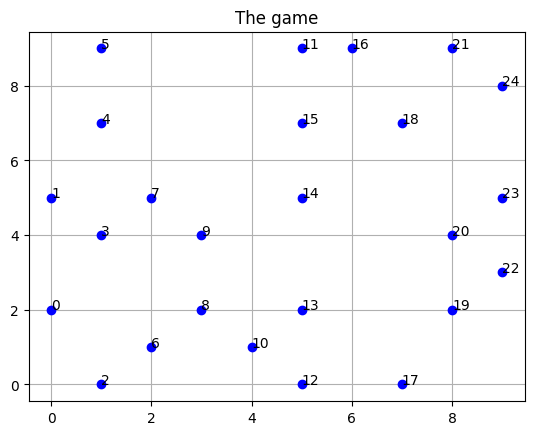

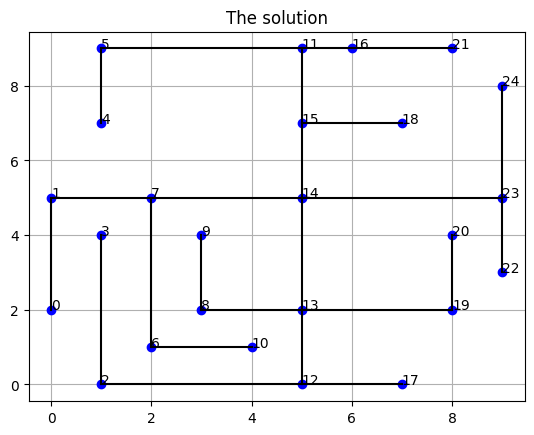

In [ ]:
existence_solver(StringIO(real_yashi_game10x10))

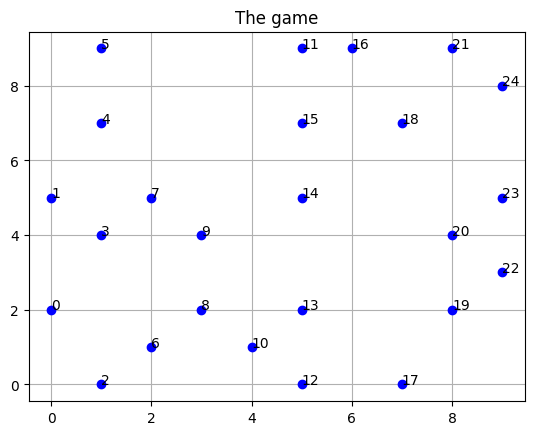

Number of solutions:  4


In [ ]:
model_counting_solver(StringIO(real_yashi_game10x10))

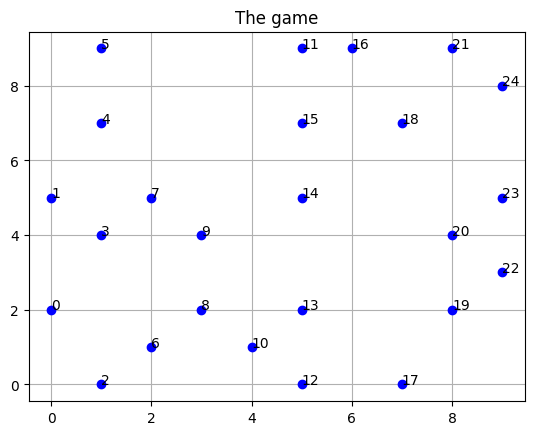

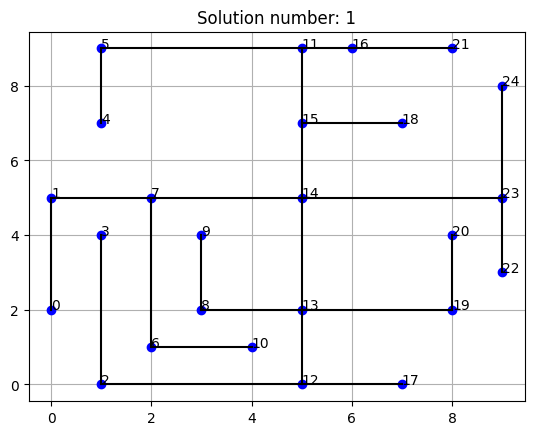

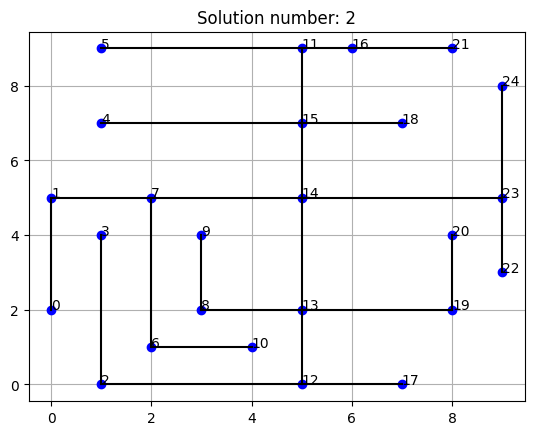

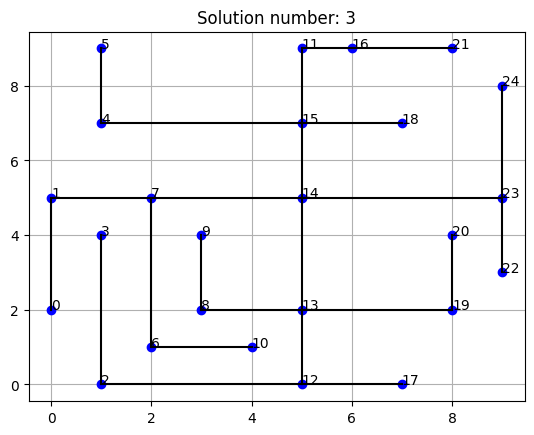

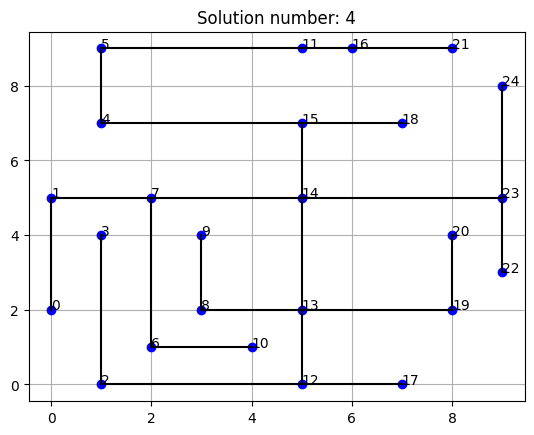

Number of solutions:  4


In [ ]:
model_counting_and_plot_solver(StringIO(real_yashi_game10x10))

### No simple cycles

In [ ]:
no_simple_cycles = """
point,x,y
0,1,2
1,1,0
2,0,1
3,2,1
4,1,1
5,0,2
6,2,2
7,0,0
8,2,0
"""

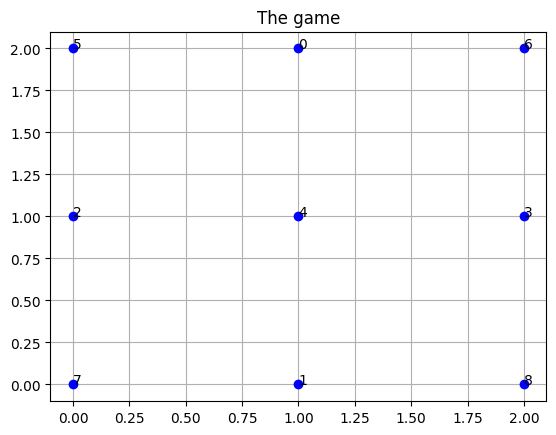

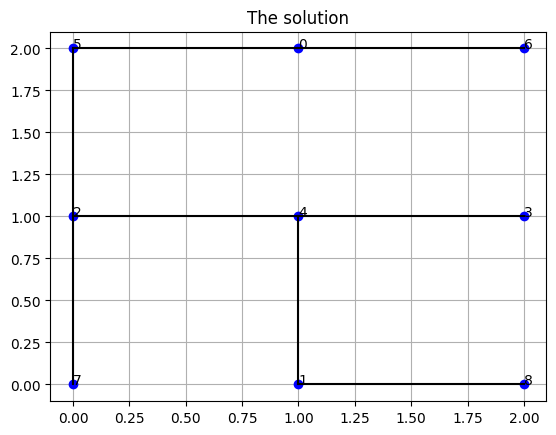

In [ ]:
existence_solver(StringIO(no_simple_cycles))

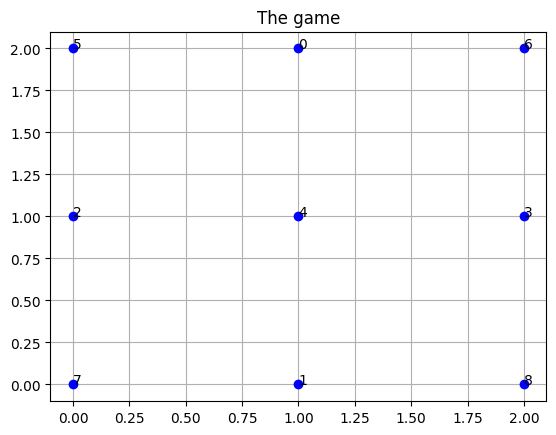

Number of solutions:  192


In [ ]:
model_counting_solver(StringIO(no_simple_cycles))

In [ ]:
model_counting_and_plot_solver(StringIO(no_simple_cycles))

Output hidden; open in https://colab.research.google.com to view.

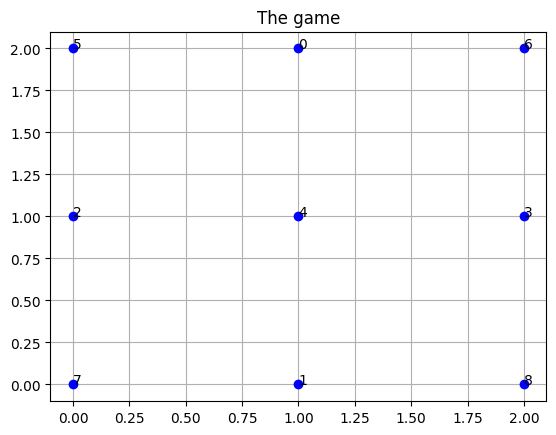

Cost of the solution:  8.0


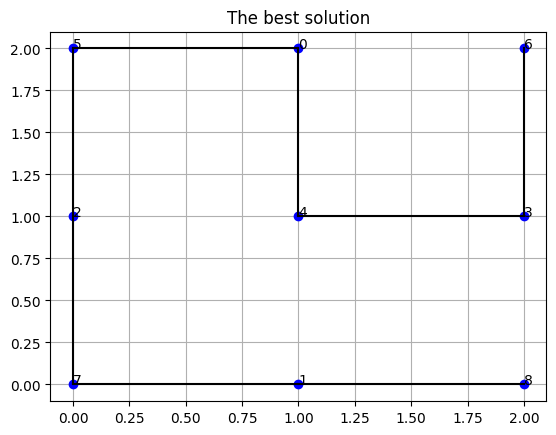

In [ ]:
best_solution_solver(StringIO(no_simple_cycles))

### A lot of cycles and crossing lines

In [ ]:
cycles_crossing_lines = """
point,x,y
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
5,4,1
6,4,2
7,4,3
8,4,4
9,1,4
10,2,4
11,3,4
12,1,0
13,2,0
14,3,0
15,4,0
"""

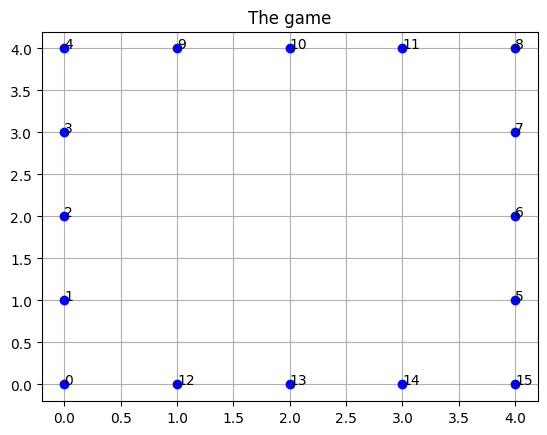

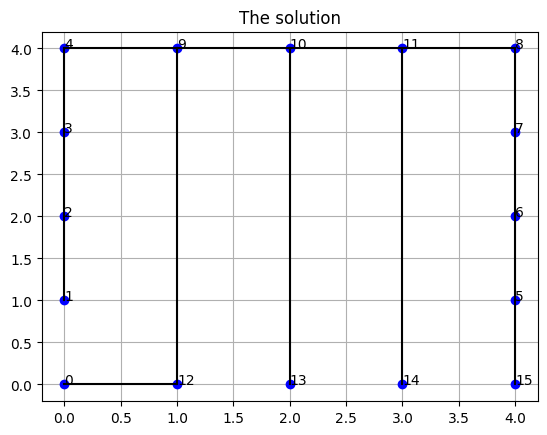

In [ ]:
existence_solver(StringIO(cycles_crossing_lines))

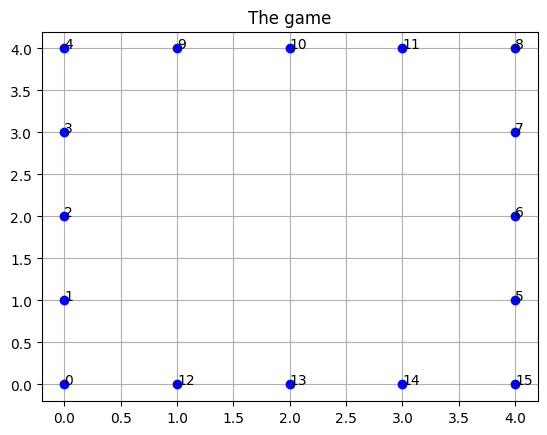

Number of solutions:  1344


In [ ]:
model_counting_solver(StringIO(cycles_crossing_lines))

In [ ]:
model_counting_and_plot_solver(StringIO(cycles_crossing_lines))

### No solution due to crossing lines

In [ ]:
no_solution_crossing_lines = """
point,x,y
0,0,1
1,0,2
2,0,3
3,4,1
4,4,2
5,4,3
6,1,4
7,2,4
8,3,4
9,1,0
10,2,0
11,3,0
12,0,4
"""

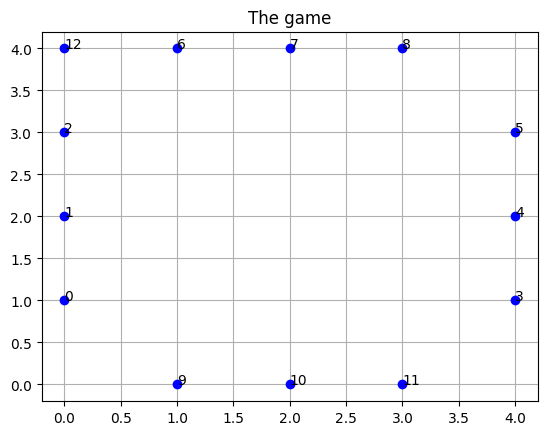

No solution


In [ ]:
existence_solver(StringIO(no_solution_crossing_lines))

### No solution due to no connection

In [ ]:
no_solution_connection = """
point,x,y
0,0,1
1,0,2
2,0,3
3,4,1
4,4,2
5,4,3
6,1,4
7,2,4
8,3,4
9,1,0
10,2,0
11,3,0
"""

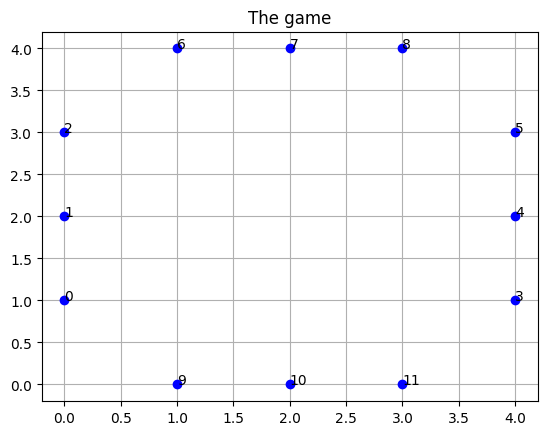

No solution


In [ ]:
existence_solver(StringIO(no_solution_connection))